In [88]:
import pandas as pd
import numpy as np
import random

import gym
from gym.spaces import Discrete, Box, Dict

from collections import OrderedDict

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import SGDRegressor

In [89]:
class Estimator():
    """
    Value Function approximator
    """
    
    def __init__(self):
        # We create a separate model for each action in the environment's
        # action space. Alternatively we could somehow encode the action
        # into the features, but this way it's easier to code up.
        self.models = []
        for _ in range(env.action_space.n):
            model = SGDRegressor(learning_rate="constant")
            # We need to call partial_fit once to initialize the model
            # or we get a NotFittedError when trying to make a prediction
            # This is quite hacky.
            model.partial_fit([np.array(list(env.reset().values()))], [0])
            self.models.append(model)
    
    def predict(self, s, a=None):
        """
        Makes value function predictions.
        
        Args:
            s: state to make a prediction for
            a: (Optional) action to make a prediction for
            
        Returns
            If an action a is given this returns a single number as the prediction.
            If no action is given this returns a vector or predictions for all actions
            in the environment where pred[i] is the prediction for action i.
            
        """
        if not a:
            return np.array([m.predict([s])[0] for m in self.models])
        else:
            return self.models[a].predict([s])[0]
    
    def update(self, s, a, y):
        """
        Updates the estimator parameters for a given state and action towards
        the target y.
        """
        self.models[a].partial_fit([s], [y])

https://github.com/dennybritz/reinforcement-learning/blob/master/FA/Q-Learning%20with%20Value%20Function%20Approximation%20Solution.ipynb

In [90]:
class LifecycleEnv(gym.Env):
    def __init__(self):
        # Here we define the choices on consumption and equity allocation
        self.action_space = Dict({"equity_allocation": Discrete(6),
                                  "consumption": Discrete(20)})
        # Set starting variables
        self.wealth = 100
        self.starting_income = 100
        self.income = self.starting_income
        self.starting_age = 20
        self.age = self.starting_age
        self.retirement_age = 21
        self.terminal_age = 25
        self.max_wealth = 10000
        self.wealth_buckets = 50
        # Here we create our observation space
        self.observation_space = Dict({"age": Discrete(self.terminal_age - self.starting_age + 1), "wealth_bucket": Discrete(self.wealth_buckets)})

    def step(self, action):
        reward = 0
        # Income reduces when you retire
        if self.age >= self.retirement_age:
            # reward += self.age * 10
            self.income = 0
        # define market returns
        risk_return = 0.05
        risk_free_return = 0.01
        # transformation
        # print(action)
        action_equity_allocation = action["equity_allocation"] / 5
        action_consumption = action["consumption"] * 10 + 10
        # Apply action
        # print(action_equity_allocation)
        portfolio_return = (risk_return * \
            action_equity_allocation) + (risk_free_return * \
            (1 - action_equity_allocation))
        start_wealth = self.wealth
        # Here income is added only after the portfolio return
        self.wealth = (1 + portfolio_return) * (self.wealth -
                                                action_consumption) + self.income
        # force wealth to be in grid - need to work on this
        if self.wealth > self.max_wealth:
            reward += (self.wealth - self.max_wealth) / 100
            self.wealth = self.max_wealth
        if self.wealth < 0:
            self.wealth = 0
            reward += -10000
            done = True
        # Time passes (philosophical consideration here)
        self.age += 1
        # Complete step if agent is older than terminal age
        if self.age == self.terminal_age:
            done = True
        else:
            done = False
        reward += action_consumption
        # Placeholder for info
        info = {"age": self.age - 1, "start_wealth": start_wealth, "wealth": self.wealth, 
                "consumption": action_consumption, "equity_allocation": action_equity_allocation, "port_return": portfolio_return}
        state = {"age": self.age - 1, "wealth_bucket": int(self.wealth/self.max_wealth * self.wealth_buckets)}
        return state, reward, done, info

    def render(self, mode='human'):
        # no urgent need for this
        pass

    def reset(self):
        # Resetting age and wealth
        self.wealth = 100
        self.age = self.starting_age
        self.income = self.starting_income
        state = {"age": self.age, "wealth_bucket": int(self.wealth/self.max_wealth)}
        return state


env = LifecycleEnv()
# Observation and action space
print("The observation space: {}".format(env.observation_space))
print("The action space: {}".format(env.action_space))


The observation space: Dict(age:Discrete(6), wealth_bucket:Discrete(50))
The action space: Dict(consumption:Discrete(20), equity_allocation:Discrete(6))


In [91]:
# Hyperparameters
minutes = 10
epochs =  int(minutes * 25000)
num_steps = env.terminal_age - env.starting_age + 1
epsilon = 1.0
learning_rate = 0.9
discount_rate = 0.9
decay_rate = 0.005

# env setup
state = env.reset()
best_action = OrderedDict()
# my q table consist of 2 state actions and 2 observation spaces
# I need to change one of the observation space variables into a continuos one and use function approximation
q_table = np.ones([env.observation_space["age"].n, env.observation_space["wealth_bucket"].n, 
    env.action_space["equity_allocation"].n, env.action_space["consumption"].n])

for epoch in range(epochs):
    state = env.reset()
    done = False
    for step in range(num_steps):
        # take random action
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()  # Explore action space
        else:
            # here I select the best action based on my q table
            q = q_table[state["age"] - env.starting_age, state["wealth_bucket"]]
            max_q_index = np.unravel_index(np.argmax(q, axis=None), q.shape)
            best_action['equity_allocation'] = max_q_index[0]
            best_action['consumption'] = max_q_index[1]
            action = best_action  # Exploit learned values

        # apply the action
        next_state, reward, done, info = env.step(action)
        if done == True:
            break
        # Update the q table
        # print(q_table.shape)
        # print(state["wealth_bucket"])
        old_value = q_table[state["age"] - env.starting_age, state["wealth_bucket"], action["equity_allocation"], action["consumption"]]
        next_max = np.max(q_table[next_state["age"] - env.starting_age, next_state["wealth_bucket"]])
        new_value = (1 - learning_rate) * old_value + learning_rate * (reward + discount_rate * next_max)
        q_table[state["age"] - env.starting_age, state["wealth_bucket"], action["equity_allocation"], action["consumption"]] = new_value

        # If the episode is up, then start another one
        state = next_state
    # this is a greedy implementation
    epsilon = np.exp(-decay_rate * epoch)

# Close the env
env.close()


In [92]:
# watch trained agent
state = env.reset()
done = False
rewards = 0
info_df = pd.DataFrame(
    columns=("age", "start_wealth", "wealth", "consumption", "equity_allocation", "port_return"))

for step in range(num_steps):
    q = q_table[state["age"] - env.starting_age, state["wealth_bucket"]]
    max_q_index = np.unravel_index(np.argmax(q, axis=None), q.shape)
    best_action['consumption'] = max_q_index[1]
    best_action['equity_allocation'] = max_q_index[0]
    new_state, reward, done, info = env.step(best_action)
    info_df = info_df.append(info, ignore_index=True) 
    rewards += reward
    state = new_state
print(rewards)

-29600


In [93]:
info_df

,age,start_wealth,wealth,consumption,equity_allocation,port_return
0,20.0,100.000000,141.040000,60.0,0.4,0.026
1,21.0,141.040000,83.147040,60.0,0.4,0.026
2,22.0,83.147040,24.119216,60.0,0.8,0.042
3,23.0,24.119216,0.000000,200.0,0.0,0.010
4,24.0,0.000000,0.000000,10.0,0.0,0.010
5,25.0,0.000000,0.000000,10.0,0.0,0.010


<AxesSubplot:xlabel='age'>

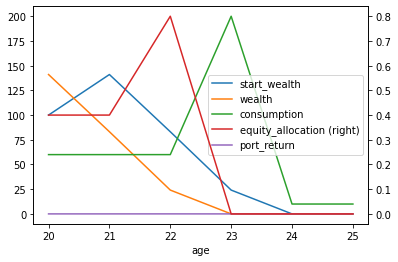

In [94]:
# print(info_df.set_index("age"))
info_df.set_index("age").plot(secondary_y=["equity_allocation"])

<AxesSubplot:>

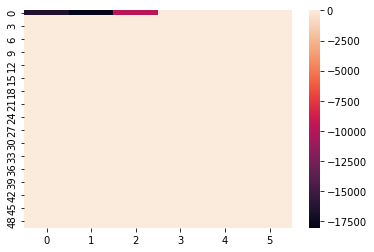

In [95]:
sns.heatmap(pd.DataFrame(q_table.mean(axis=3).mean(axis=2)).T)

<AxesSubplot:>

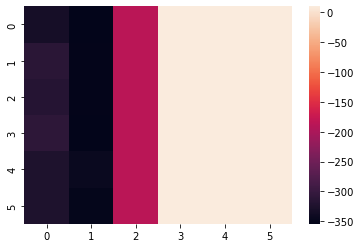

In [96]:
sns.heatmap(pd.DataFrame(q_table.mean(axis=3).mean(axis=1)).T)

<AxesSubplot:>

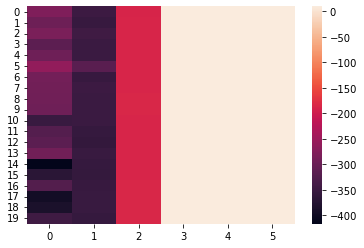

In [97]:
sns.heatmap(pd.DataFrame(q_table.mean(axis=1).mean(axis=1)).T)